# TaskRabbit Take Home Assignment 

### Applicant: Yu-Ting Shen

# Question 1:

### Some Context:
Clients arriving on the platform fill-out a task creation form describing tasks to be done. TaskRabbit’s ranking algorithm generates an ordered list of available Taskers, represented by a tasker_id. (It may be helpful to create a task in the app for more context).

For this exercise, a sample data file is provided which contains information about a client’s task search ( represented by a funnel_search_id) . A “funnel_search_id" can be more clearly defined as an ID that represents a search instance that produced a group of Taskers from which the Client can choose to book given their search criteria.

The columns are defined as follows:

|Column Name|Description|
|:---|:---|
|funnel_search_id|unique identifier for this recommendation/instance|
|timestamp|time of the search|
|tasker_id|unique identifier for the Tasker displayed as a result of the search|
|position|the position of the Tasker in the recommendation set, 1 - first, 2 - second, etc.|
|hourly_rate|the hourly rate for the Tasker when they were shown|
|num_completed_tasks|the number of Tasks the Tasker had completed in that category, when they were shown|
|hired|Was the Tasker hired or not? Only one tasker out of a set of recommendations can be hired|
|category|the category of work the Client needs help with|

### Task: Conduct a brief EDA on the data and build a predictive model. 
### Deliverable: Jupyter notebook, PDF or laTex of your EDA and Model

Notes and constraints
* Make sure the submission has your code, relevant plots, etc
* Make sure your model selection is supported, or suggested by your EDA
* Document any assumptions you’ve made
* Include a brief write-up/interpretation of your results
* Don’t spend too much time on this task, we are looking for basic proficiency and
familiarity, not for complex models.
* Include some metric for measuring performance for your predictive model
* Don’t worry about hyper-parameter tuning, accuracy, etc

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Load dataset and show the first 5 rows
df = pd.read_csv('takehome_data_(2).csv')
display(df.head())

,funnel_search_id,created_at,tasker_id,position,hourly_rate,num_completed_tasks,hired,category
0,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,9/1/17 0:32,1009185352,1,38,151,0,Furniture Assembly
1,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,9/1/17 0:32,1006892359,2,40,193,0,Furniture Assembly
2,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,9/1/17 0:32,1012023956,3,28,0,0,Furniture Assembly
3,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,9/1/17 0:32,1009733517,4,43,303,0,Furniture Assembly
4,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,9/1/17 0:32,1013579273,5,29,39,0,Furniture Assembly


In [66]:
# Because the created_at column is a timestamp, it is better to convert the format into datetime64[ns]
df['created_at'] = pd.to_datetime(df['created_at'], infer_datetime_format=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   funnel_search_id     30000 non-null  object        
 1   created_at           30000 non-null  datetime64[ns]
 2   tasker_id            30000 non-null  int64         
 3   position             30000 non-null  int64         
 4   hourly_rate          30000 non-null  int64         
 5   num_completed_tasks  30000 non-null  int64         
 6   hired                30000 non-null  int64         
 7   category             30000 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 1.8+ MB


### EAD

* Show number of unque values in each column

In [67]:
# Print the number of unique items in each column
for col in df.columns:
    value = df[col].nunique()
    print(f'Number of unique {col}: {value}')

Number of unique funnel_search_id: 2100
Number of unique created_at: 1489
Number of unique tasker_id: 830
Number of unique position: 15
Number of unique hourly_rate: 82
Number of unique num_completed_tasks: 964
Number of unique hired: 2
Number of unique category: 3


#### Now look at `created_at` column

Because there is a timestamp column `created_at`, we can
* check the date range in the data
* create new columns: `date` and `weekday`
* count how many searches are made in each date
* count how many hire decisions are mand in each date

In [68]:
min_date = df['created_at'].min()
max_date = df['created_at'].max()
print(f'Date range: {min_date} to {max_date}')

Date range: 2017-09-01 00:32:00 to 2017-09-30 23:15:00


Average search per date: 70.0
Average hire decision per date: 56.83


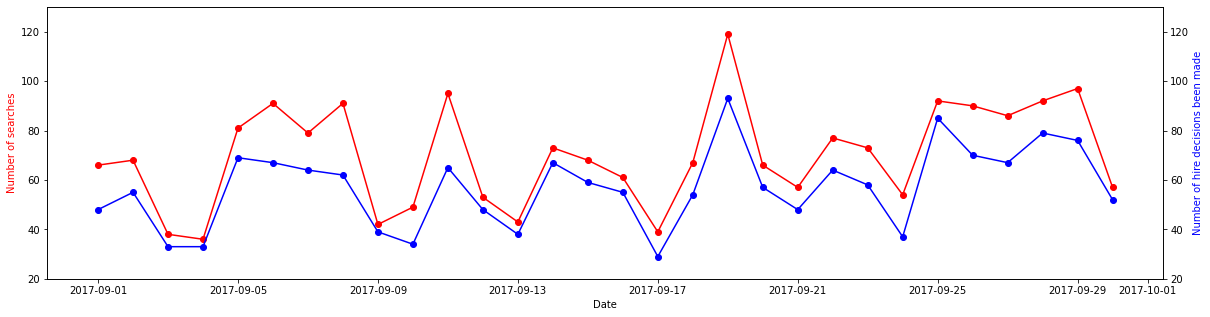

In [69]:
df['date'] = df['created_at'].dt.date
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df['weekday'] = df['created_at'].dt.weekday # Monday = 0 and Sunday = 6

count_search_per_date = {}
count_hire_per_date = {}
for d in df['date'].unique():
    df_sub = df.loc[df['date']==d]
    number_of_search = df_sub['funnel_search_id'].nunique()
    number_of_hire_decision = df_sub['hired'].sum()
    
    count_search_per_date[d] = number_of_search
    count_hire_per_date[d] = number_of_hire_decision
    
# print(count_search_per_date)
# print(count_hire_per_date)

avg_search = sum(count_search_per_date.values()) / len(count_search_per_date.values())
avg_search = round(avg_search, 2)

avg_hire = sum(count_hire_per_date.values()) / len(count_hire_per_date.values())
avg_hire = round(avg_hire, 2)

print(f'Average search per date: {avg_search}')
print(f'Average hire decision per date: {avg_hire}')



fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(count_search_per_date.keys(), count_search_per_date.values(), 
        marker='o', color='red', label='Number of searchs')
ax.set_xlabel('Date')
ax.set_ylabel('Number of searches', color='red')
ax.set_ylim((20, 130))

ax2 = ax.twinx()
ax2.plot(count_hire_per_date.keys(), count_hire_per_date.values(), 
         marker='o', color='blue', label='Number of hire decisions')
ax2.set_ylabel('Number of hire decisions been made', color='blue')
ax2.set_ylim((20, 130))

plt.show()

The above plot shows the blue line (number of hire decisions been made) is lower than the red line (number of search). This means not all the search made a hire decision. Some clients only search the available taskers but they didn't hire any one.

There are about 70 searches per day and only 56.83 of the searches had made the hiring decision.

Now make a plot which shows the ratio between number of hire decisions been made and number of search for each day.

Average hiring decision making ratio = 81.89


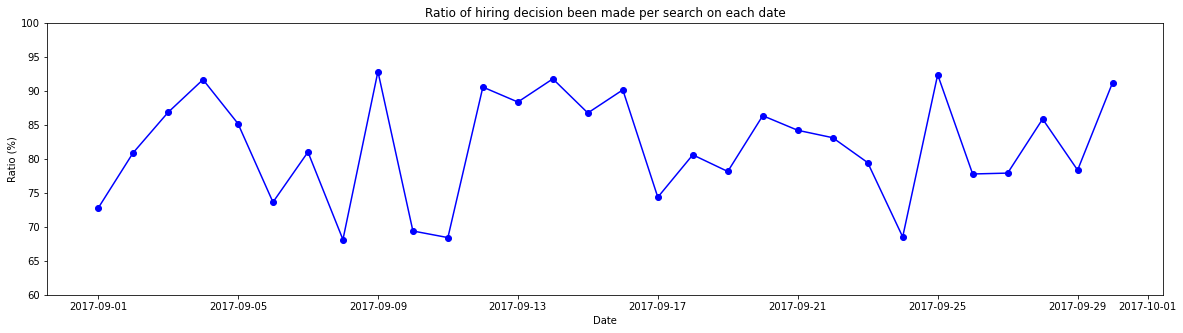

In [70]:
hire_decision_ratio_per_search = {}

for d in df['date'].unique():
    num_search = count_search_per_date[d]
    num_hire_decision = count_hire_per_date[d]
    ratio = round(num_hire_decision / num_search * 100, 2)
    hire_decision_ratio_per_search[d] = ratio
    
# print(hire_decision_ratio_per_search)
avg_ratio = sum(hire_decision_ratio_per_search.values()) / len(hire_decision_ratio_per_search.values())
avg_ratio = round(avg_ratio, 2)
print(f'Average hiring decision making ratio = {avg_ratio}')


fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(hire_decision_ratio_per_search.keys(), hire_decision_ratio_per_search.values(), 
        marker='o', color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Ratio (%)')
ax.set_title('Ratio of hiring decision been made per search on each date')
ax.set_ylim((60, 100))
plt.show()

#### Now look at `category` column

Categories: ['Furniture Assembly' 'Moving Help' 'Mounting']
{'Furniture Assembly': 702, 'Moving Help': 693, 'Mounting': 705}
* 33.43% of the searches belong to Furniture Assembly
* 33.0% of the searches belong to Moving Help
* 33.57% of the searches belong to Mounting


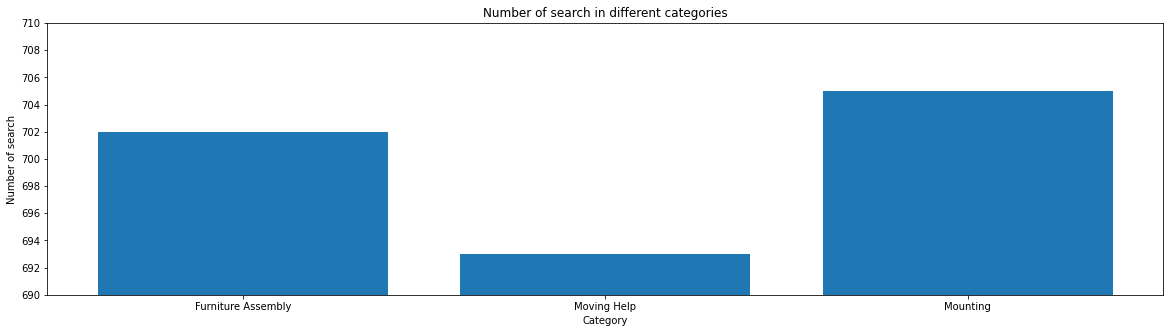

In [71]:
print(f'Categories: {df["category"].unique()}')


count_category_to_search = {}
for val in df['category'].unique():
    df_sub = df.loc[df['category']==val]
    count_category_to_search[val] = df_sub['funnel_search_id'].nunique()

print(count_category_to_search)

total_searches = sum(count_category_to_search.values())
for k, v in count_category_to_search.items():
    ratio = round(v / total_searches * 100, 2)
    print(f'* {ratio}% of the searches belong to {k}')



fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(x=range(len(count_category_to_search)), height=count_category_to_search.values())
ax.set_xticks(range(len(count_category_to_search)))
ax.set_xticklabels(count_category_to_search.keys())
ax.set_xlabel('Category')
ax.set_ylabel('Number of search')
ax.set_ylim((690, 710))
ax.set_yticks(range(690, 711, 2))
ax.set_title('Number of search in different categories')
plt.show()

There are 3 categories and each of category has similar number of searches.

#### Now look at `funnel_search_id` column:

* Because one task search (i.e. one `funnel_search_id`) returns 1 to 15 `tasker_id`, I would like to know how many search been made per number of `tasker_id`

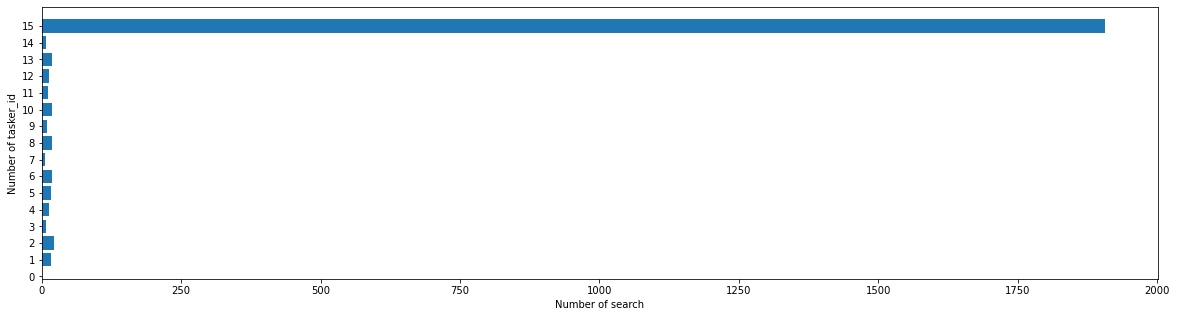

In [72]:


from collections import Counter
cnt = Counter(df['funnel_search_id'])

# Calculate the number of tasker_id per search
map_num_tasker_id_and_search = {}
for k, v in cnt.items():
    # k is the funnel_search_id
    # v is the number of returned tasker_id
    if v not in map_num_tasker_id_and_search.keys():
        map_num_tasker_id_and_search[v] = 1
    else:
        map_num_tasker_id_and_search[v] += 1
        
# print(map_num_tasker_id_and_search)
# print(sorted(map_num_tasker_id_and_search.items(), key=lambda item: item[0]))

x_val = []
y_val = []
for k, v in map_num_tasker_id_and_search.items():
    x_val.append(k)
    y_val.append(v)
# print(x_val)
# print(y_val)
# print(sum(y_val))

fig, ax = plt.subplots(figsize=(20, 5))
# sns.barplot(x=, y=, ax=ax)
plt.barh(x_val, y_val)
ax.set_ylabel('Number of tasker_id')
ax.set_xlabel('Number of search')
ax.set_yticks(range(len(x_val)+ 1))
plt.show()

The above plot shows there are 
* 1906 `funnel_search_id` return 15 different `tasker_id`
* 8 `funnel_search_id` return 14 different `tasker_id`
* 18 `funnel_search_id` return 13 different `tasker_id`
* 13 `funnel_search_id` return 12 different `tasker_id`
* 11 `funnel_search_id` return 11 different `tasker_id`
* 19 `funnel_search_id` return 10 different `tasker_id`
* 10 `funnel_search_id` return 9 different `tasker_id`
* 18 `funnel_search_id` return 8 different `tasker_id`
* 6 `funnel_search_id` return 7 different `tasker_id`
* 19 `funnel_search_id` return 6 different `tasker_id`
* 16 `funnel_search_id` return 5 different `tasker_id`
* 12 `funnel_search_id` return 4 different `tasker_id`
* 7 `funnel_search_id` return 3 different `tasker_id`
* 21 `funnel_search_id` return 2 different `tasker_id`
* 16 `funnel_search_id` return 1 different `tasker_id`

Most of search return 15 available taskers.

From the intuition, we assume if the search returns only one `tasker_id`, then this tasker will be hired. If the research returns two `tasker_id`, then one of them will be hired. However, in our previous study, the hiring decisions been made is only about 81% of the search. This means the client might only search but didn't hire anyone. Now I am going to varify this

In [73]:
# list of funnel_search_id which return number of tasker_id
indexes_1 = [] # has 1 tasker_id
indexes_2 = [] # has 2 tasker_id
indexes_3 = [] # has 3 tasker_id

for k, v in cnt.items():
    if v == 1:
        indexes_1.append(k)
    elif v == 2:
        indexes_2.append(k)
    elif v == 3:
        indexes_3.append(k)
        
# display(df.loc[df['funnel_search_id'].isin(indexes_1)])
# display(df.loc[df['funnel_search_id'].isin(indexes_2)])

In [74]:
df.loc[
    (df['funnel_search_id']=='0-0-a8505aa9-636a-4c8a-aac1-109090d04fda') |
    (df['funnel_search_id']=='0-0-b34b79e8-27ad-43eb-9e8f-b5313d1f53fc')
]

,funnel_search_id,created_at,tasker_id,position,hourly_rate,num_completed_tasks,hired,category,date,weekday
474,0-0-a8505aa9-636a-4c8a-aac1-109090d04fda,2017-09-01 16:22:00,1008042586,1,65,452,0,Mounting,2017-09-01,4
475,0-0-b34b79e8-27ad-43eb-9e8f-b5313d1f53fc,2017-09-01 16:22:00,1008042586,1,65,452,0,Mounting,2017-09-01,4


The above example shows there is only one `tasker_id` available for `funnel_search_id=0-0-a8505aa9-636a-4c8a-aac1-109090d04fda` and `funnel_search_id=0-0-b34b79e8-27ad-43eb-9e8f-b5313d1f53fc`, the tasker didn't get hired."

In [75]:
df.loc[
    (df['funnel_search_id']=='0-0-6c3909bb-f721-4df6-90bf-9668aa8376ca') |
    (df['funnel_search_id']=='0-0-8523fb44-74dd-4795-bade-88b63090289c') |
    (df['funnel_search_id']=='0-0-66c45202-5eaf-4ca2-8a54-7324c4de54ec') |
    (df['funnel_search_id']=='0-0-5a8940db-daa3-4878-b62f-ed5daad9c07a') |
    (df['funnel_search_id']=='0-0-2e447413-9e12-4d48-ac36-8f1e672f5fa0')
]

,funnel_search_id,created_at,tasker_id,position,hourly_rate,num_completed_tasks,hired,category,date,weekday
6209,0-0-6c3909bb-f721-4df6-90bf-9668aa8376ca,2017-09-07 19:54:00,1013597448,1,44,17,0,Mounting,2017-09-07,3
6210,0-0-6c3909bb-f721-4df6-90bf-9668aa8376ca,2017-09-07 19:54:00,1014586046,2,85,338,0,Mounting,2017-09-07,3
9771,0-0-8523fb44-74dd-4795-bade-88b63090289c,2017-09-11 18:55:00,1012164831,1,75,17,0,Furniture Assembly,2017-09-11,0
9772,0-0-8523fb44-74dd-4795-bade-88b63090289c,2017-09-11 18:55:00,1014157578,2,100,236,0,Furniture Assembly,2017-09-11,0
25167,0-0-66c45202-5eaf-4ca2-8a54-7324c4de54ec,2017-09-26 19:14:00,1007283421,1,75,169,0,Moving Help,2017-09-26,1
25168,0-0-66c45202-5eaf-4ca2-8a54-7324c4de54ec,2017-09-26 19:14:00,1014251534,2,145,101,0,Moving Help,2017-09-26,1
25175,0-0-5a8940db-daa3-4878-b62f-ed5daad9c07a,2017-09-26 19:15:00,1007283421,1,75,169,0,Moving Help,2017-09-26,1
25176,0-0-5a8940db-daa3-4878-b62f-ed5daad9c07a,2017-09-26 19:15:00,1014251534,2,145,101,0,Moving Help,2017-09-26,1
28729,0-0-2e447413-9e12-4d48-ac36-8f1e672f5fa0,2017-09-29 18:10:00,1009703547,1,145,326,0,Moving Help,2017-09-29,4
28730,0-0-2e447413-9e12-4d48-ac36-8f1e672f5fa0,2017-09-29 18:10:00,1009194244,2,175,26,0,Moving Help,2017-09-29,4


Similarly, the above example shows there are two `tasker_id`s available in a search, but none of the tasker get hired.

#### Therefore, some of the clients simply do the search but they don't hire any tasker.

Now I want to know how many percentage of
* taskers who is the first `position` and get hired
* taskers who offer the lowest `hourly_rate` and get hired
* taskers who have the highest `num_completed_tasks` and get hired

In [76]:
# Create a new dataframe which is recommended in first position
df_first_position = (
    df.groupby(['funnel_search_id', 'created_at', 'category'])[['position']]
      .min()
      .reset_index()
)
df_first_position['first_position'] = 1
# display(df_first_position.head())

# Create a new dataframe which label the lowest hourly rate
df_lowest_hourly_rate = (
    df.groupby(['funnel_search_id', 'created_at', 'category'])[['hourly_rate']]
      .min()
      .reset_index()
)
df_lowest_hourly_rate['lowest_rate'] = 1
# display(df_lowest_hourly_rate)


# Create a new dataframe which labels the highes number of completed tasks
df_highest_num_completed_tasks = (
    df.groupby(['funnel_search_id', 'created_at', 'category'])[['num_completed_tasks']]
      .max()
      .reset_index()
)
df_highest_num_completed_tasks['highest_completed_tasks'] = 1
# display(df_highest_num_completed_tasks)

df_new = pd.merge(
    df,
    df_first_position,
    on=['funnel_search_id', 'created_at', 'category', 'position'],
    how='left'
).fillna(value={'first_position':0})
# display(df_new.head(15))

df_new = df_new.merge(
    df_lowest_hourly_rate,
    on=['funnel_search_id', 'created_at', 'category', 'hourly_rate'],
    how='left'
).fillna(value={'lowest_rate': 0})
# display(df_new.head(15))

df_new = df_new.merge(
    df_highest_num_completed_tasks,
    on=['funnel_search_id', 'created_at', 'category', 'num_completed_tasks'],
    how='left'
).fillna(value={'highest_completed_tasks': 0})
# display(df_new.head(15))

In [77]:
# calculate the ratio which the lowest rate taskers get hired
df_hired = df_new.loc[df_new['hired']==1]
# display(df_hired.head())


ratio_tasker_is_first_position_get_hired = \
    round(sum(df_hired['first_position']) / len(df_hired) * 100, 2)
ratio_tasker_with_lowest_rate_get_hired = \
    round(sum(df_hired['lowest_rate']) / len(df_hired) * 100, 2)
ratio_tasker_with_highest_completed_tasks_get_hired = \
    round(sum(df_hired['highest_completed_tasks']) / len(df_hired) * 100, 2)

print(f'Tasker is first position get_hired = {ratio_tasker_is_first_position_get_hired}%')
print(f'Tasker with lowest rate get hired = {ratio_tasker_with_lowest_rate_get_hired}%')
print(f'Tasker with highest_completed_tasks_get_hired = {ratio_tasker_with_highest_completed_tasks_get_hired}%')

Tasker is first position get_hired = 36.66%
Tasker with lowest rate get hired = 15.37%
Tasker with highest_completed_tasks_get_hired = 11.14%


Because the ratios are less than 20%, the clients might decide to hire a tasker for other reasons.

If we check the above ratio in each category

In [78]:
# calculate the ratio which the lowest rate taskers get hired
for cat in df_new['category'].unique():
    df_hired = df_new.loc[
        (df_new['hired']==1)&
        (df_new['category']==cat)
    ]
    # display(df_hired.head())
    
    ratio_tasker_is_first_position_get_hired = (
        round(sum(df_hired['first_position']) / len(df_hired) * 100, 2)
    )
    
    ratio_tasker_with_lowest_rate_get_hired = (
        round(sum(df_hired['lowest_rate']) / len(df_hired) * 100, 2)
    )
    ratio_tasker_with_highest_completed_tasks_get_hired = (
        round(sum(df_hired['highest_completed_tasks']) / len(df_hired) * 100, 2)
    )
    
    print(f'In {cat} category:')
    print(f'* Tasker is first position get hired = {ratio_tasker_is_first_position_get_hired}%')
    print(f'* Tasker with lowest rate get hired = {ratio_tasker_with_lowest_rate_get_hired}%')
    print(f'* Tasker with highest completed tasks get hired = {ratio_tasker_with_highest_completed_tasks_get_hired}%')
    print('\n')

In Furniture Assembly category:
* Tasker is first position get hired = 40.91%
* Tasker with lowest rate get hired = 16.26%
* Tasker with highest completed tasks get hired = 13.11%


In Moving Help category:
* Tasker is first position get hired = 33.45%
* Tasker with lowest rate get hired = 20.32%
* Tasker with highest completed tasks get hired = 7.71%


In Mounting category:
* Tasker is first position get hired = 35.59%
* Tasker with lowest rate get hired = 9.43%
* Tasker with highest completed tasks get hired = 12.63%




Because the ratio of "tasker is first position get hired" is greater 30%, the ratios of "tasker with lowest rate get hired" and "tasker with highest completed tasks get hired" are less than 20%, I think that there is higher possibility the clients choose the tasker in the first position. The clients might not select the tasker based on their hourly rate or completed tasks.

#### Now look at `tasker_id` column:
I want to know who are the top taskers been hired

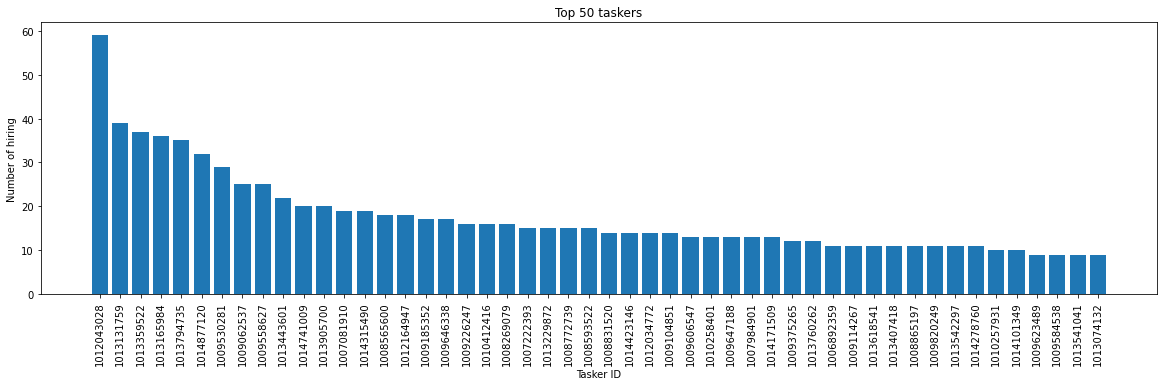

In [79]:
tasker_number_of_hired = {}
for tasker in df['tasker_id'].unique():
    df_sub = df[df['tasker_id']==tasker]
    number_of_hired = df_sub['hired'].sum()
    tasker_number_of_hired[tasker] = number_of_hired
# print(tasker_number_of_hired)

list_tasker_number_of_hired = []
for k, v in tasker_number_of_hired.items():
    list_tasker_number_of_hired.append((k, v))
    
sorted_tasker_number_of_hired = sorted(list_tasker_number_of_hired, key=lambda x: x[1], reverse=True)
# print(sorted_tasker_number_of_hired)

list_of_taskers = []
number_of_hiring = []
for item in sorted_tasker_number_of_hired:
#     print(item[0], item[1])
    list_of_taskers.append(item[0])
    number_of_hiring.append(item[1])

fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(x=range(50), height=number_of_hiring[:50])
ax.set_xlabel('Tasker ID')
ax.set_ylabel('Number of hiring')
ax.set_xticks(range(50))
ax.set_xticklabels(list_of_taskers[:50], rotation=90)
ax.set_title('Top 50 taskers')
plt.show()

hourly rate of top tasker_id

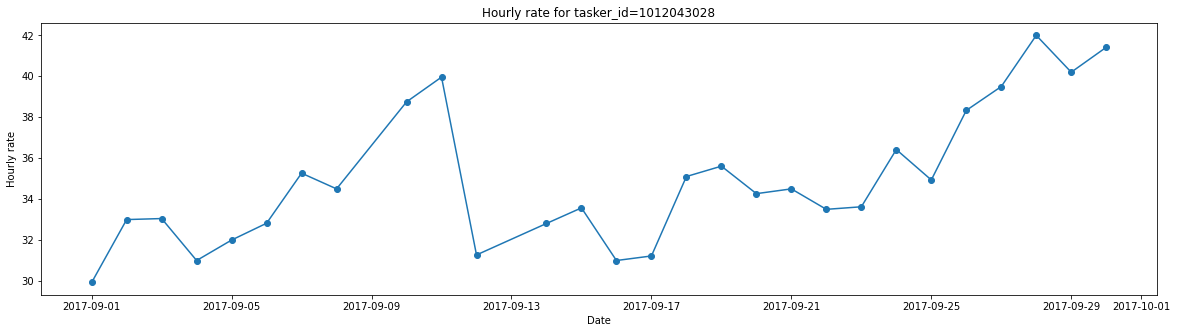

In [80]:
df_sub = df[df['tasker_id']==list_of_taskers[0]]
df_sub_group = df_sub.groupby(['date'])[['hourly_rate']].mean().reset_index()
# display(df_sub_group.head())

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_sub_group['date'], df_sub_group['hourly_rate'], marker='o')
ax.set_xlabel('Date')
ax.set_ylabel('Hourly rate')
ax.set_title(f'Hourly rate for tasker_id={list_of_taskers[0]}')
plt.show()

## Model

* Use random forest and gradient boosting to forecast hired or not hired.
* Use date < 2017-09-25 as training set and date >= 2017-09-25 as testing set
* Apply one-hot encoding on `position`, `category`, `weekday`

In [81]:
df_onehot_position = pd.get_dummies(df['position'], prefix='position')
df_onehot_category = pd.get_dummies(df['category'], prefix='category')
df_onehot_weekday = pd.get_dummies(df['weekday'], prefix='weekday')

In [88]:
df_new2 = pd.concat([df_new ,df_onehot_position, df_onehot_category, df_onehot_weekday], axis=1)
# print(df_new2.columns)

selected_cols = df_new2.columns.difference([
    'funnel_search_id', 'created_at', 'position', 'weekday', 'category'
])

df_train = df_new2.loc[df_new2['date']<'2017-09-25', selected_cols]
df_test = df_new2.loc[df_new2['date']>='2017-09-25', selected_cols]
# display(df_train.head())

X_train = df_train[df_train.columns.difference(['date', 'hired'])].values
y_train = df_train['hired'].values

X_test = df_test[df_test.columns.difference(['date', 'hired'])].values
y_test = df_test['hired'].values

# print(X_train)
# print(y_train)

# print(X_test)
# print(y_test)

In [95]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

gbc = GradientBoostingClassifier(max_depth=6)
rfc = RandomForestClassifier(n_estimators=300)

model_gbc = gbc.fit(X_train, y_train)
model_rfc = rfc.fit(X_train, y_train)

y_pred_gbc = model_gbc.predict(X_test)
y_pred_rfc = model_rfc.predict(X_test)

In [99]:
from sklearn.metrics import classification_report
report_gbc = classification_report(y_test, y_pred_gbc)
print(report_gbc)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      6942
           1       0.37      0.13      0.19       429

    accuracy                           0.94      7371
   macro avg       0.66      0.56      0.58      7371
weighted avg       0.91      0.94      0.92      7371



In [100]:
report_rfc = classification_report(y_test, y_pred_rfc)
print(report_rfc)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      6942
           1       0.39      0.11      0.17       429

    accuracy                           0.94      7371
   macro avg       0.67      0.55      0.57      7371
weighted avg       0.92      0.94      0.92      7371



In [102]:
from sklearn.metrics import confusion_matrix
matrix_gbc = confusion_matrix(y_test, y_pred_gbc)
print(matrix_gbc)

[[6848   94]
 [ 374   55]]


In [103]:
matrix_rfc = confusion_matrix(y_test, y_pred_rfc)
print(matrix_rfc)

[[6867   75]
 [ 381   48]]


# Question 2

## Design of Experiment

Consider you want to design an experiment around a new feature in TaskRabbit in order to test the impact on job conversion. The nature of the feature is not important, just the measurement of the impact. In this question develop a brief testing plan that will be submitted to the Product Manager. Please review/consider the following as you design your experiment:

### Constraints:
1. Randomization cannot be guaranteed in the deployment of this feature

### Notes:
* The final deliverable should be understandable by a non-tech audience
* Document any assumptions you make about the data available (i.e. traffic size, etc), access to external testing tools, engineering resources, etc
* Feel free to make and document any assumptions regarding the definition of “job conversion” as it pertains to your testing plan
* Try to add detail around your testing plan that justifies the model/strategy you’ve chosen

### Deliverable: A brief testing plan to be delivered to the Product Manager

### Answer

The clients search the available taskers on TaskRabbit, and they can decide whether or not hire a tasker from the search results. Therefore, the definition of "job conversion" is the clients search available taskers and decide to hire one of the taskers. And I assume that the new feature which may impact the job conversion is "reviews" of each taskers. The reviews can be from one star to five stars, the more stars, the better taskers. 

The control group is the one without reviews in the search results, and the testing group is the one with reviews in the search results. By measuring how many clients make a hire decision in the control and testing group, it is possible to measure the impact on the "job conversion".

The null hypothesis is that there is no difference between control group and testing group. Therefore, the mean value of the job convertion rate, which is the ratio between number of hiring decision been made and the number of search been submitted, in these two groups are the same. Then we can start to collect the data for the experiment. There are many way to collect data and the easiest way is trying to collect 1,000 queries from different clients in both groups. If the job conversion ratio between these two groups are similar, then the new feature "reviews" cause no impact. If the job conversion ratio between these two groups has significantly differences and the $p$-value is less then 0.05, then we can conclude the new feature does impact on the job conversion.